In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/nasa_power_data.csv")

print("df head")
print(df.head())

print("df info")
print(df.info())

print("df description")
print(df.describe())

df head
   PV_Production    T2M  T2M_MAX  T2M_MIN  WS2M  PRECTOTCORR   RH2M  \
0          12.47  21.63    26.91    17.34  3.01         0.07  71.32   
1          14.41  21.61    26.07    17.63  2.66         0.03  70.74   
2          13.14  21.61    26.07    17.79  3.21         0.11  74.88   
3          16.56  21.72    25.78    18.85  3.20         0.56  76.08   
4           9.39  21.69    25.98    18.55  2.46         0.43  74.26   

   ALLSKY_KT  ALLSKY_SFC_SW_DNI  CLRSKY_SFC_SW_DNI  ALLSKY_SFC_SW_DIFF  \
0       0.70              30.13              33.16                7.07   
1       0.69              28.71              34.45                6.93   
2       0.71              33.13              34.45                5.45   
3       0.61              23.78              29.82                8.30   
4       0.67              23.83              28.58                8.34   

   CLRSKY_SFC_SW_DIFF  ALLSKY_SFC_SW_DWN  CLRSKY_SFC_SW_DWN  \
0                5.88              28.55              29.

In [ ]:
# Replace -999 with np.nan
df.replace("", np.nan, inplace=True)

# Drop rows with any NaNs
df.dropna(inplace=True)

# Reset index after dropping
df.reset_index(drop=True, inplace=True)

# Optional: verify
print(df.isna().sum())  # Should all be 0 now
print(df.shape)         # See how many rows remain

PV_Production         0
T2M                   0
T2M_MAX               0
T2M_MIN               0
WS2M                  0
PRECTOTCORR           0
RH2M                  0
ALLSKY_KT             0
ALLSKY_SFC_SW_DNI     0
CLRSKY_SFC_SW_DNI     0
ALLSKY_SFC_SW_DIFF    0
CLRSKY_SFC_SW_DIFF    0
ALLSKY_SFC_SW_DWN     0
CLRSKY_SFC_SW_DWN     0
ALLSKY_SFC_LW_DWN     0
CLRSKY_SFC_LW_DWN     0
ALLSKY_SFC_LW_UP      0
CLRSKY_SFC_LW_UP      0
dtype: int64
(730, 18)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

X = df.drop('PV_Production', axis=1)
y = df['PV_Production']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
X_pca_scaled = pca.fit_transform(X_scaled)

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import catboost as cb
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.035, random_state=42)

models = {
    'XGBoostRegressor': xgb.XGBRegressor(
        n_estimators=5000,
        learning_rate=0.001,
        max_depth=25,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        early_stopping_rounds=10
    ),
    'RandomForestRegressor': RandomForestRegressor(
        n_estimators=5000,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        warm_start=True
    ),
    'SVR': SVR(
        C=500,
        gamma='scale',
        kernel='rbf',
        epsilon=0.01
    ),
    'CatBoostRegressor': cb.CatBoostRegressor(
        iterations=5000,
        learning_rate=0.001,
        depth=6,
        l2_leaf_reg=3,
        subsample=0.8,
        colsample_bylevel=0.8,
        random_state=42,
        verbose=False,
        early_stopping_rounds=10
    ),
    'ANN': MLPRegressor(
        hidden_layer_sizes=(100, 50, 25),
        learning_rate_init=0.001,
        alpha=0.01,
        batch_size='auto',
        solver='adam',
        max_iter=10000,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=10,
        random_state=42
    ),
    'GradientBoostingRegressor': GradientBoostingRegressor(
        n_estimators=5000,
        learning_rate=0.001,
        max_depth=25,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=42,
        validation_fraction=0.2,
        n_iter_no_change=10
    )
}

results = {}
for name, model in models.items():
    if name in ['XGBoostRegressor', 'CatBoostRegressor']:
        model.fit(X_train_split, y_train_split, eval_set=[(X_val, y_val)])
    else:
        model.fit(X_train_split, y_train_split)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R2', ascending=False)
print(results_df)

[0]	validation_0-rmse:3.00720
[1]	validation_0-rmse:3.00713
[2]	validation_0-rmse:3.00643
[3]	validation_0-rmse:3.00607
[4]	validation_0-rmse:3.00444
[5]	validation_0-rmse:3.00308
[6]	validation_0-rmse:3.00195
[7]	validation_0-rmse:3.00124
[8]	validation_0-rmse:2.99991
[9]	validation_0-rmse:2.99914
[10]	validation_0-rmse:2.99748
[11]	validation_0-rmse:2.99547
[12]	validation_0-rmse:2.99459
[13]	validation_0-rmse:2.99351
[14]	validation_0-rmse:2.99201
[15]	validation_0-rmse:2.99059
[16]	validation_0-rmse:2.98925
[17]	validation_0-rmse:2.98862
[18]	validation_0-rmse:2.98697
[19]	validation_0-rmse:2.98532
[20]	validation_0-rmse:2.98419
[21]	validation_0-rmse:2.98306
[22]	validation_0-rmse:2.98172
[23]	validation_0-rmse:2.98064
[24]	validation_0-rmse:2.97887
[25]	validation_0-rmse:2.97538
[26]	validation_0-rmse:2.97368
[27]	validation_0-rmse:2.97256
[28]	validation_0-rmse:2.97200
[29]	validation_0-rmse:2.96977
[30]	validation_0-rmse:2.96797
[31]	validation_0-rmse:2.96595
[32]	validation_0-

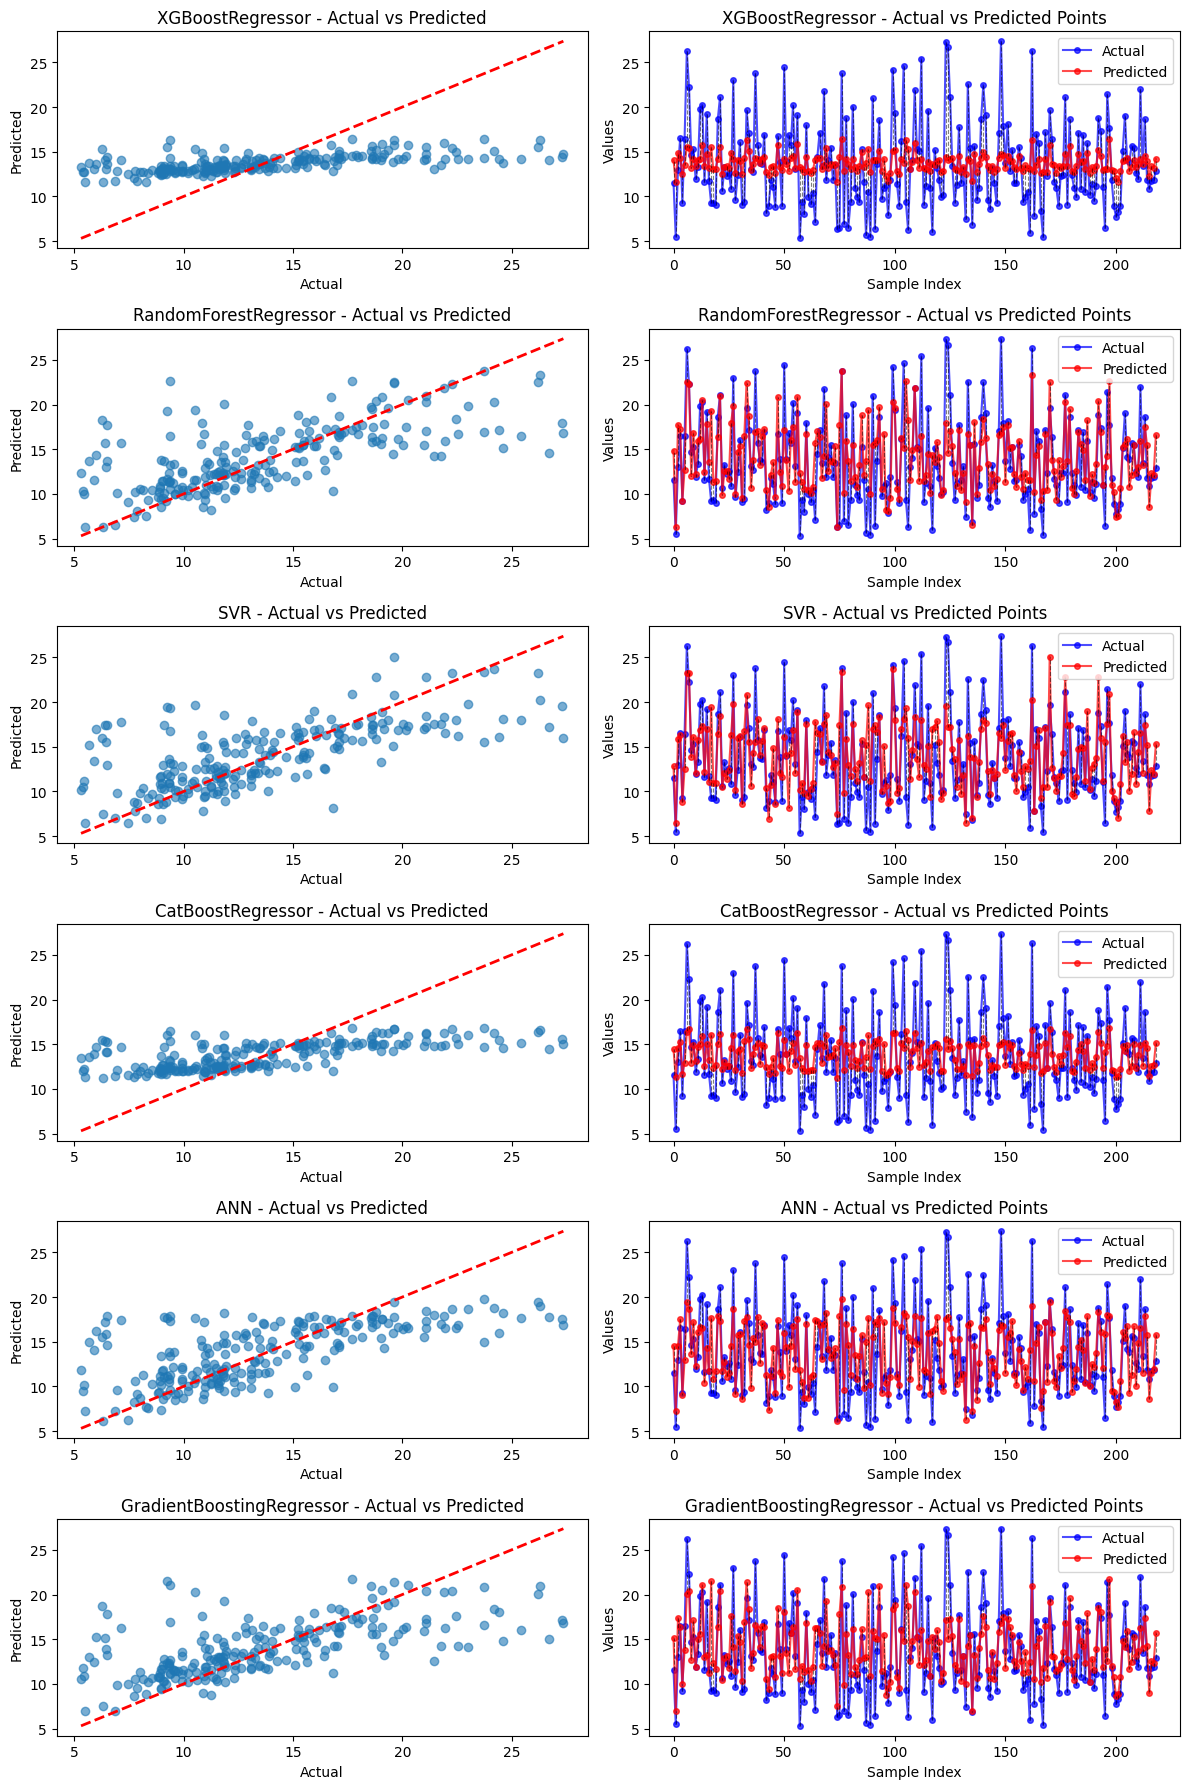

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(len(models), 2, figsize=(12, 3*len(models)))

for i, (name, model) in enumerate(models.items()):
   y_pred = model.predict(X_test)

   axes[i, 0].scatter(y_test, y_pred, alpha=0.6)
   min_val = min(y_test.min(), y_pred.min())
   max_val = max(y_test.max(), y_pred.max())
   axes[i, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
   axes[i, 0].set_xlabel('Actual')
   axes[i, 0].set_ylabel('Predicted')
   axes[i, 0].set_title(f'{name} - Actual vs Predicted')

   x_points = range(len(y_test))
   axes[i, 1].plot(x_points, y_test, 'bo-', label='Actual', alpha=0.7, markersize=4)
   axes[i, 1].plot(x_points, y_pred, 'ro-', label='Predicted', alpha=0.7, markersize=4)
   for j in x_points:
       axes[i, 1].plot([j, j], [y_test.iloc[j], y_pred[j]], 'k--', alpha=0.5, linewidth=0.8)
   axes[i, 1].set_xlabel('Sample Index')
   axes[i, 1].set_ylabel('Values')
   axes[i, 1].set_title(f'{name} - Actual vs Predicted Points')
   axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

top_models = {
    'SVR': models['SVR'],
    'RandomForestRegressor': models['RandomForestRegressor']
}

ensemble_predictions = []
model_weights = []

for name, model in top_models.items():
    pred = model.predict(X_test)
    ensemble_predictions.append(pred)

    r2_score_val = r2_score(y_test, pred)
    model_weights.append(r2_score_val)

ensemble_predictions = np.array(ensemble_predictions)
model_weights = np.array(model_weights)
normalized_weights = model_weights / np.sum(model_weights)

simple_avg_pred = np.mean(ensemble_predictions, axis=0)

weighted_avg_pred = np.average(ensemble_predictions, axis=0, weights=normalized_weights)

simple_avg_mse = mean_squared_error(y_test, simple_avg_pred)
simple_avg_r2 = r2_score(y_test, simple_avg_pred)

weighted_avg_mse = mean_squared_error(y_test, weighted_avg_pred)
weighted_avg_r2 = r2_score(y_test, weighted_avg_pred)

ensemble_results = {
    'Simple_Average_Ensemble': {'MSE': simple_avg_mse, 'R2': simple_avg_r2},
    'Weighted_Average_Ensemble': {'MSE': weighted_avg_mse, 'R2': weighted_avg_r2}
}

print("Individual Model Performance:")
for name in top_models.keys():
    pred = top_models[name].predict(X_test)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(f"{name}: MSE={mse:.6f}, R2={r2:.6f}")

print(f"\nModel Weights: {dict(zip(top_models.keys(), normalized_weights))}")
print(f"\nEnsemble Results:")
print(f"Simple Average Ensemble: MSE={simple_avg_mse:.6f}, R2={simple_avg_r2:.6f}")
print(f"Weighted Average Ensemble: MSE={weighted_avg_mse:.6f}, R2={weighted_avg_r2:.6f}")

Individual Model Performance:
SVR: MSE=13.600133, R2=0.443014
RandomForestRegressor: MSE=13.703764, R2=0.438770

Model Weights: {'SVR': np.float64(0.5024065671791553), 'RandomForestRegressor': np.float64(0.4975934328208447)}

Ensemble Results:
Simple Average Ensemble: MSE=13.146567, R2=0.461589
Weighted Average Ensemble: MSE=13.146329, R2=0.461599


In [ ]:
import pickle
import numpy as np

ensemble_model = {
    'models': {
        'SVR': models['SVR'],
        'GradientBoostingRegressor': models['GradientBoostingRegressor']
    },
    'weights': {
        'SVR': 0.5278699325387907,
        'GradientBoostingRegressor': 0.47213006746120934
    }
}

with open('weighted_ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)

print("Model saved successfully!")

def load_ensemble_model(filepath):
    with open(filepath, 'rb') as f:
        ensemble_model = pickle.load(f)
    return ensemble_model

def predict_ensemble(ensemble_model, X_new):
    models = ensemble_model['models']
    weights = ensemble_model['weights']

    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_new)

    weighted_pred = sum(weights[name] * predictions[name] for name in models.keys())

    return weighted_pred

loaded_model = load_ensemble_model('weighted_ensemble_model.pkl')

# Make predictions on new data
# X_new should have the same feature columns as your training data
# new_predictions = predict_ensemble(loaded_model, X_new)

Model saved successfully!
